In [1]:
from abc import abstractmethod
from dataclasses import dataclass
from typing import Callable, Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

## InterestRateSimulation
The default parameters in this class likely need to be changed. Update steps for the borrow, demand, and interest rate calculations can be modified for different simulation logic as well.

## IRMetrics
The `IRMetrics` subclasses will take an `InterestRateSimulation` object and return a float. This metric class is written this way to have a unified way of exposing various data from a sim to a potential metric that we might define. For instance, we might consider a metric that only uses information about the utilization time series, whereas another metric might consider both the utilization and the interest rate time series. In either case, the `InterestRateSimulation` object has access to both time series.

In [2]:
@dataclass
class InterestRateSimulation:
    T: int = 100          # time
    dt: float = 0.001
    B0: float = 1.6
    D0: float = 2
    U0: float = 0.8
    r0: float = 0.01
    rB_bar: float = 0.05  # USDC borrow rate
    rD_bar: float = 0.04  # USDC deposit rate
    beta_B: float = 20
    beta_D: float = 10
    sigma_B: float = 0.6
    sigma_D: float = 0.2
    k_p: float = 1.5
    k_d: float = 2
    u_target: float = 0.8
    seed: int = 0
    update_interval: int = 100
    
    def __post_init__(self):
        self.nsteps = int(self.T / self.dt)
        self.B = np.zeros(self.nsteps)    # borrows
        self.D = np.zeros(self.nsteps)    # deposits
        self.u = np.zeros(self.nsteps)    # utilization
        self.r = np.zeros(self.nsteps)    # interest rates

        self.e = np.zeros(self.nsteps)        # errors
        self.delta_e = np.zeros(self.nsteps)  # delta error
        self.jump = np.zeros(self.nsteps)     
        self.speed = np.zeros(self.nsteps)
        np.random.seed(self.seed)
    
    def simulate(self):
        B, D, u, r = self.B, self.D, self.u, self.r
        e, delta_e, speed, jump = self.e, self.delta_e, self.speed, self.jump
        self.D[0] = self.D0
        self.B[0] = self.B0
        self.u[0] = self.U0
        self.r[0] = self.r0

        b_noise = np.random.normal(size=self.nsteps + 1)
        d_noise = np.random.normal(size=self.nsteps + 1)
        speed_prev = 0
        r_prev = 0
        
        for t in range(1, self.nsteps):
            if t % self.update_interval == 1:
                # Calculate change in borrow and deposits per Blue IRM documentation
                db = self.beta_B * (self.rB_bar - r[t-1]) * self.dt + (self.sigma_B * np.sqrt(self.dt) * b_noise[t])
                dd = self.beta_D * (r[t - 1] * (self.B[t-1] / D[t-1]) - self.rD_bar) * self.dt + (self.sigma_D * np.sqrt(self.dt) * d_noise[t])
                # Avoid small negative floats by clamping to 0
                self.D[t] = max(self.D[t-1] + dd, 1e-4)
                self.B[t] = max(min(self.B[t-1] + db, self.D[t]), 1e-4) # ensure borrows < deposits
                self.u[t] = max(self.B[t] / self.D[t], 1e-4)
                
                # MB described error adjustment
                e[t] = self.u[t] - self.u_target
                if e[t] > 0:
                    e[t] = e[t] / (1 - self.u_target)
                else:
                    e[t] = e[t] / self.u_target

                # update the interest rate
                delta_e[t] = e[t] - e[t-1]
                speed[t] = self.k_p * e[t]
                jump[t] = self.k_d**delta_e[t]
                r[t] = r[t-1] * jump[t] * (1 + speed[t] * self.dt)

                # bookkeeping
                r_prev = r[t]
                speed_prev = speed[t]
            else:
                # only the rate should change
                r[t] = r_prev * (1 + speed_prev * (t%self.update_interval) * self.dt)
                self.B[t] = self.B[t-1]
                self.D[t] = self.D[t-1]
                self.u[t] = max(self.B[t] / self.D[t], 1e-4)
                self.e[t] = self.u[t] - self.u_target
                delta_e[t] = e[t] - e[t-1]
                
def liquidity(u: np.ndarray, u_thresh: float=0.98, penalty: float=0.2):
    n = len(u)
    u_crit = 0
    consec = 0
    for i in range(n):
        if u[i] >= u_thresh:
            consec += 1
            u_crit += (1 + penalty * consec)
        else:
            consec = 0
    return u_crit
    
def ise(U: np.ndarray, u_target: float):
    error = np.sum((U - u_target)**2)
    return error

def ise_pos(U: np.ndarray, u_target: float):
    mask = U > u_target
    error = np.sum(((U[mask] - u_target)/(1-u_target))**2)
    return error

def volatility(R, nb_t):
    return np.sqrt(nb_t/365) * np.std(np.diff(np.log(R))) 

def volatility_percentile(R, nb_t, percentile):
    log_returns = np.diff(np.log(R))
    filtered_log_returns = log_returns[(log_returns > np.percentile(log_returns, percentile)) & (log_returns < np.percentile(log_returns, 100-percentile))]
    return np.sqrt(nb_t/365) * np.std(filtered_log_returns)
    
class IRMetric:
    @abstractmethod
    def __call__(self, sim: InterestRateSimulation):
        pass

class Liquidity(IRMetric):
    def __init__(self, u_thresh: float = 0.95, penalty: float=0.2):
        self.penalty = penalty
        self.u_thresh = u_thresh
        
    def __call__(self, sim: InterestRateSimulation):
        return liquidity(sim.u, self.u_thresh, self.penalty)

class ISE(IRMetric):
    def __call__(self, sim: InterestRateSimulation):
        u, u_target = sim.u, sim.u_target
        return ise(u, u_target)

class PLiq(IRMetric):
    def __init__(self, u_thresh: float = 0.95):
        self.u_thresh = u_thresh
        
    def __call__(self, sim: InterestRateSimulation):
        return (sim.u > self.u_thresh).sum() / len(sim.u)

class TargetRateProximity(IRMetric):
    def __init__(self, radius=0.05):
        self.radius = radius
        
    def __call__(self, sim: InterestRateSimulation):
        return ((sim.u <= sim.u_target + self.radius) & (sim.u >= sim.u_target - self.radius)).sum() / len(sim.u)

## Plot Borrow/Demand/Utilization/Interest Rates
Quick visual sanity check to see if the parameters of the `InterestRateSimulation` make sense. Adjust the parameters of the simulation by setting them in the `InterestRateSimulation` constructor.

  0%|                                                                                                                                                                                | 0/2 [00:00<?, ?it/s]

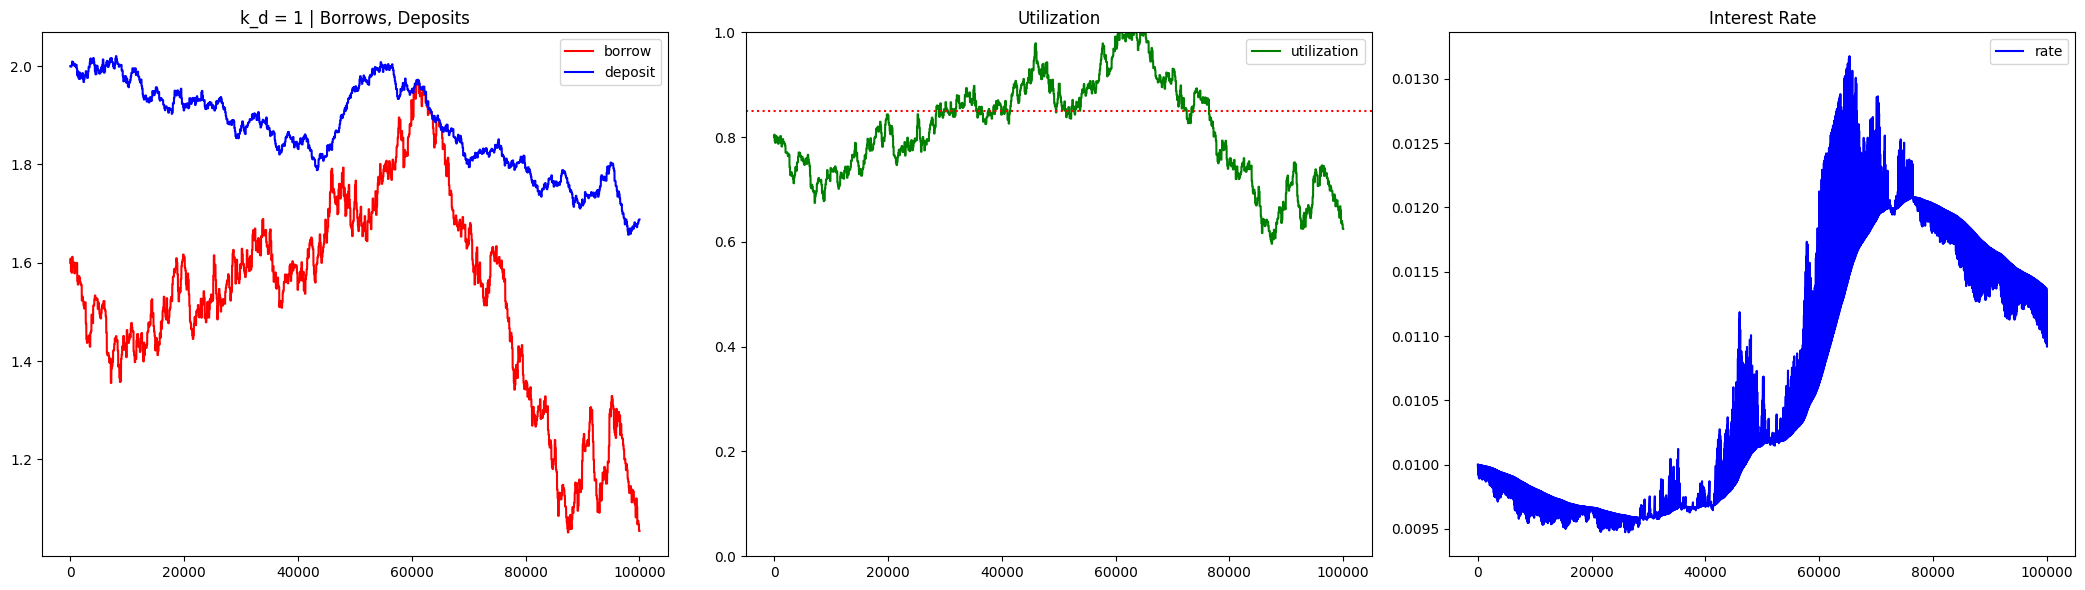

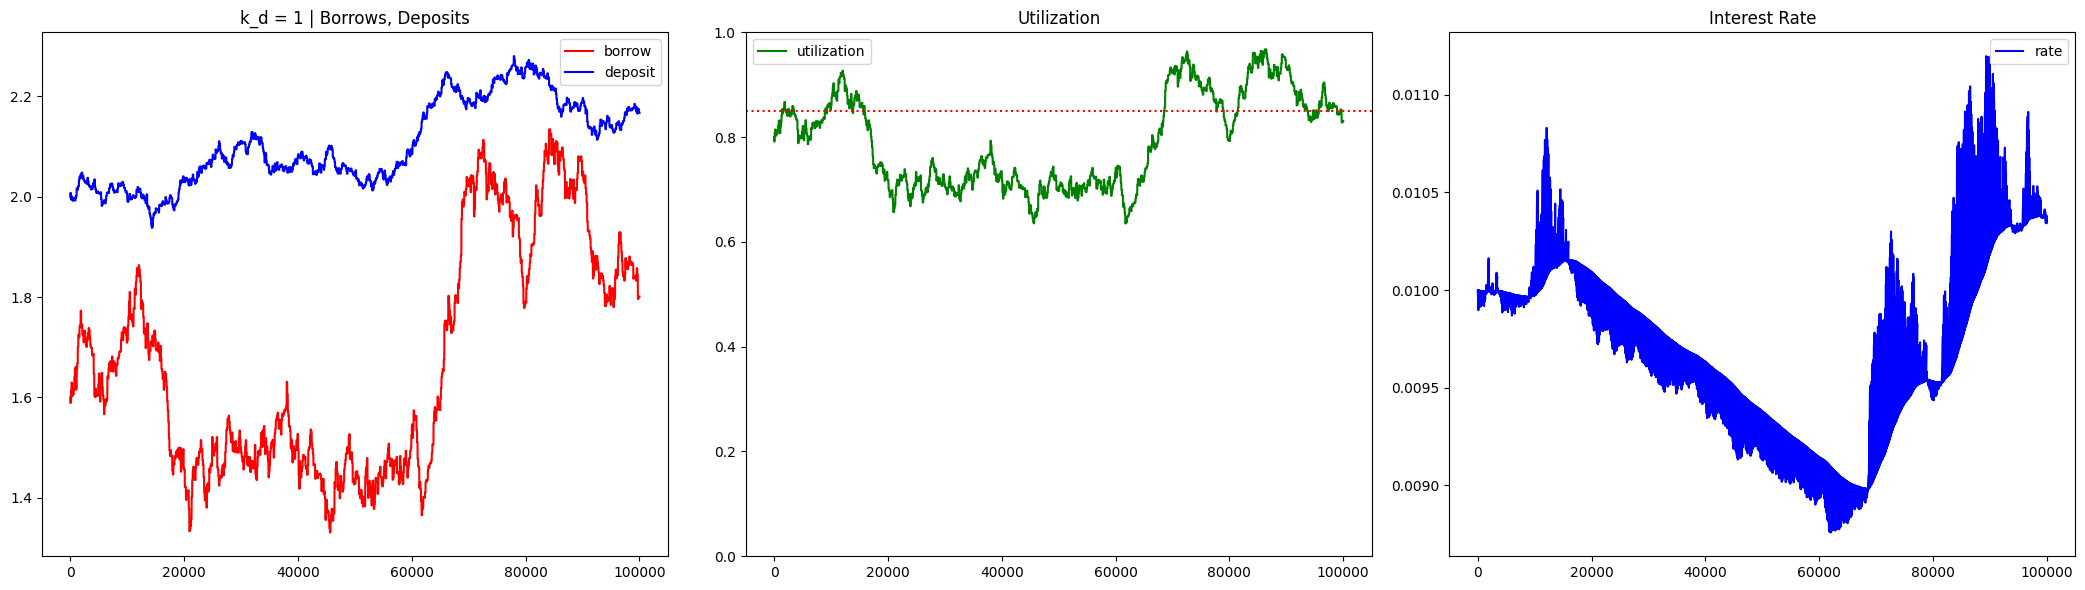

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1/2 [00:01<00:01,  1.04s/it]

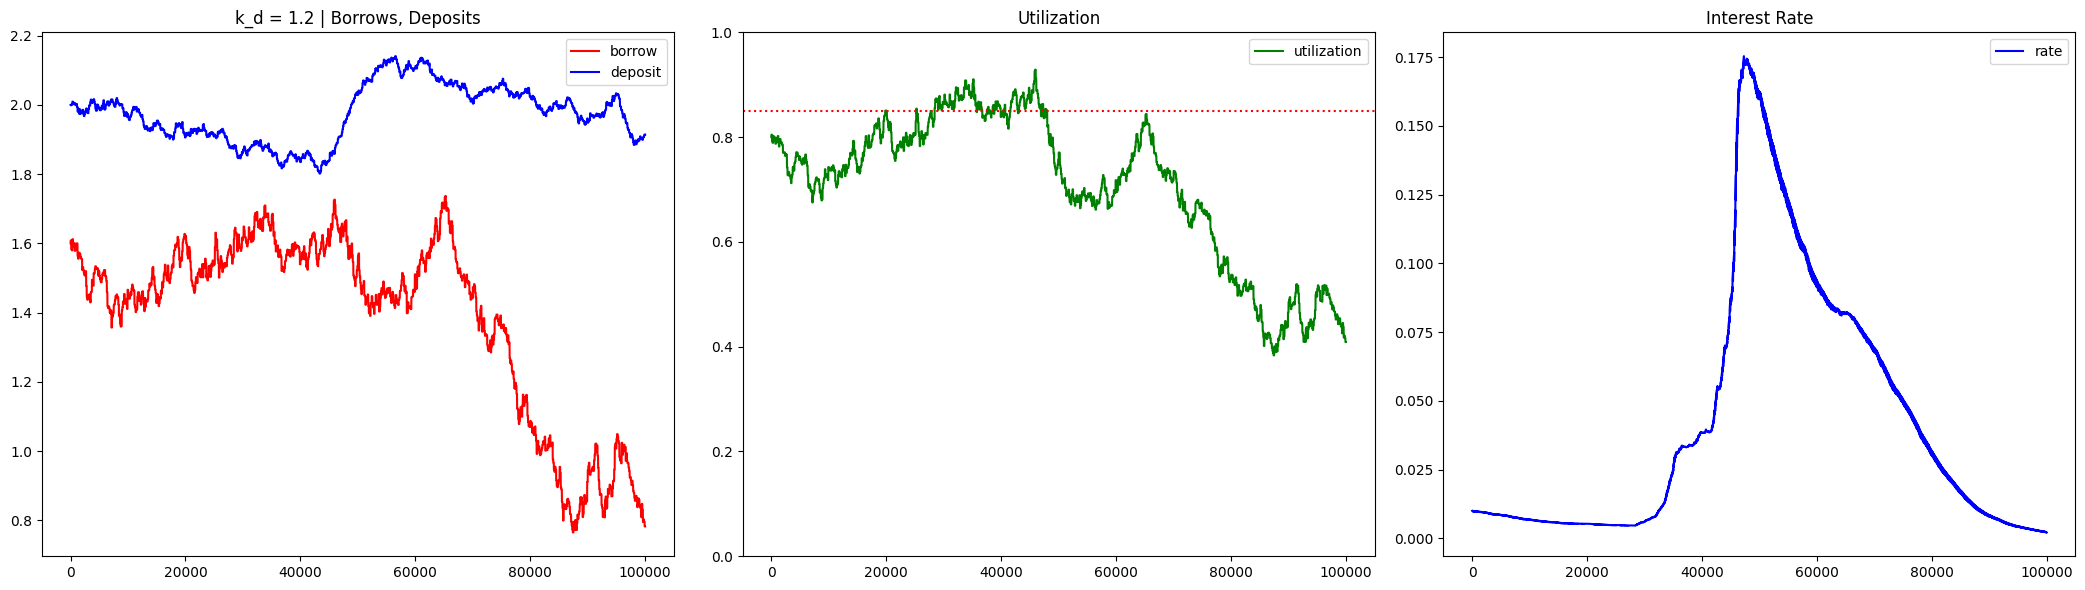

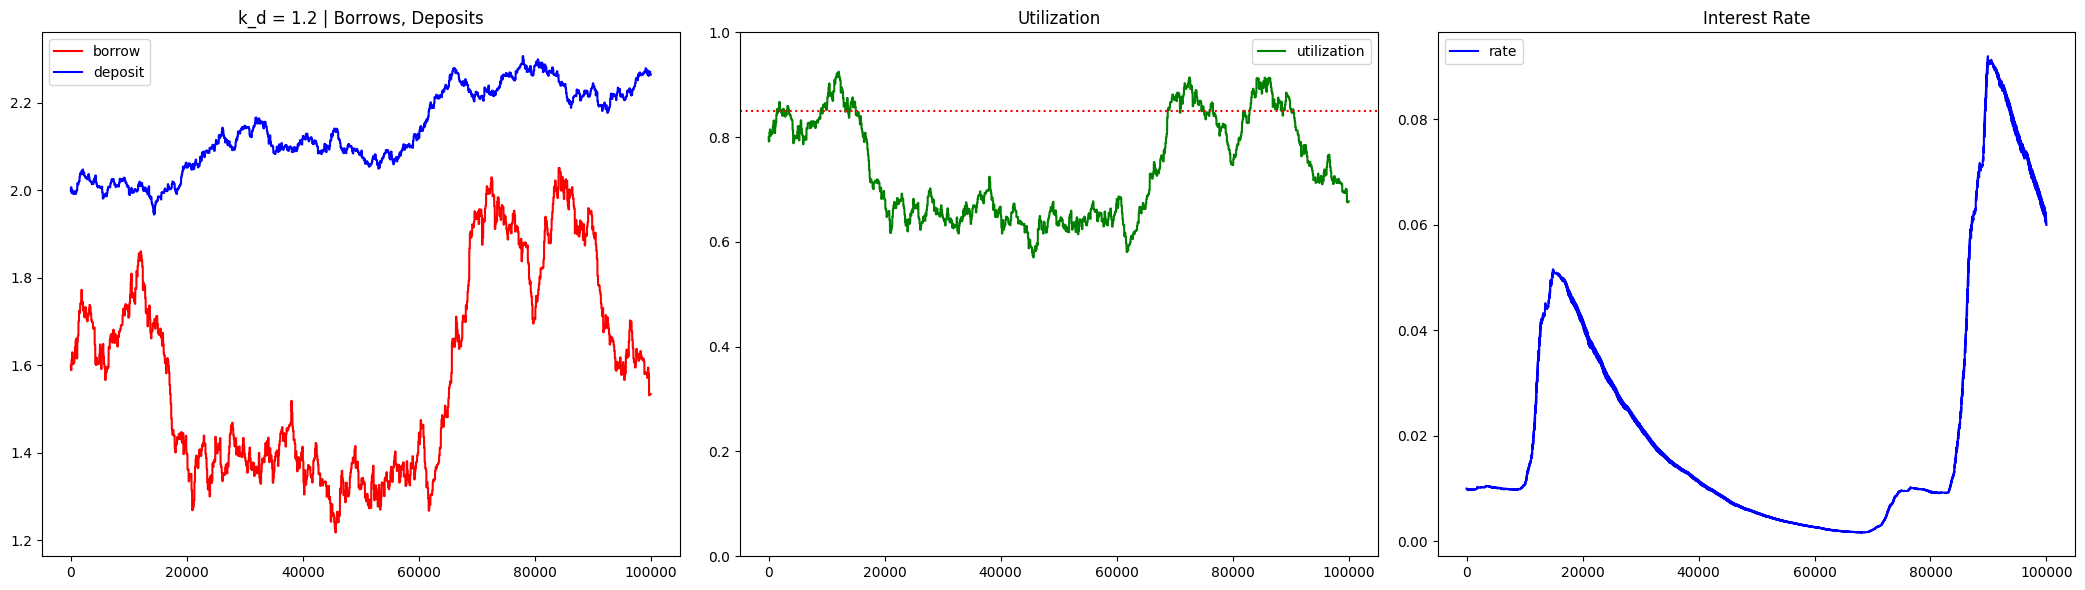

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


In [3]:
u_target = 0.85
# Can also instead loop over a different parameter
for k_d in tqdm([1, 1.2]):
    for seed in range(2):
        sim = InterestRateSimulation(k_d=k_d, u_target=u_target, seed=seed, update_interval=100)
        sim.simulate()
        # continue
    
        # Just eyeballing but we can look at more random seeds if desired
        plt.figure(figsize=(21, 6))
        plt.subplot(1, 3, 1)
        plt.plot(sim.B, color='r', label='borrow')
        plt.plot(sim.D, color='b', label='deposit')
        plt.legend()
        plt.title(f"k_d = {k_d} | Borrows, Deposits")
        
        plt.subplot(1, 3, 2)
        plt.plot(sim.u, color='g', label='utilization')
        plt.axhline(y=u_target, color='r', linestyle='dotted')
        plt.ylim(0, 1)
        plt.legend()
        plt.title("Utilization")
    
        plt.subplot(1, 3, 3)
        plt.plot(sim.r, color='b', label='rate')
        plt.legend()
        plt.title("Interest Rate")
        plt.tight_layout()
        plt.show()

In [4]:
from scipy.optimize import minimize
from typing import Callable, Iterable, Tuple
import numpy as np


def sim_eval(
    n_seeds: int,
    metric: Callable[[InterestRateSimulation], float],
    aggregate: Callable[[Iterable[float]], float] = np.mean,
) -> Callable[[Tuple[float, float]], float]:
    def f(x: Tuple[float, float]) -> float:
        k_p, k_d = x
        results = []
        
        for s in range(n_seeds):
            # May need to modify the default parameters set in InterestRateSimulation
            sim = InterestRateSimulation(
                    k_p=k_p,
                    k_d=k_d,
                    u_target=0.85,
                    seed=s
            )
            sim.simulate()
            results.append(metric(sim))  # Changed from eval_metric to metric
        return -aggregate(results)

    return f

metric = TargetRateProximity(radius=0.075)
f = sim_eval(10, metric=metric)
k_p_init, k_d_init = 1.5, 2
init_args = (k_p_init, k_d_init)
bounds = [(1, 3), (0, 3)] # Nelder Mead doesnt accept bounds. Can bake the bounds into the metric though if so desired

%time result = minimize(f, init_args, method='Nelder-Mead')

CPU times: user 59.7 s, sys: 239 ms, total: 60 s
Wall time: 1min


In [6]:
print("k_p: {:.2f}, k_d: {:.2f}".format(*result.x))

k_p: 1.57, k_d: 2.10
